In [1]:
%run packages_imported.py
%run EDA.py

from sklearn.svm import SVC

In [2]:
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')

In [3]:
t1 = time.time() 
X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 0 seconds


## SVC

Full dataset

In [8]:
t1 = time.time() 

tfidfconverter = TfidfVectorizer(min_df=0.0001, max_df=0.98)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))


EDA.process_time(round(time.time()-t1))


MemoryError: Unable to allocate 76.7 GiB for an array with shape (221982, 46391) and data type float64

It appears that we cannot create a TF-IDF matrix with pandas dataframe in full dataset. It is impossible to load 76GB in RAM. Therefore we explored other options as Dask dataframes where it loads the dataframe in the hard drive instead of memory

In [3]:
import dask_ml
import dask_ml.feature_extraction.text
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.model_selection import train_test_split

In [4]:
import dask.dataframe as dd
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')
df_all_news_processed = dd.from_pandas(df_all_news_processed, npartitions=3)
df_all_news_processed.head()

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show sinc...,tracy morgan performs first stand-up show sinc...,entertainment,186
1,President Barack Obama interviews author Maril...,information president barack obama interviews ...,entertainment,148
2,"I will perform at night clubs, shows β€“ Pasto...",source ghana hitz euphemia akpalu date time pm...,entertainment,181
3,MEG Records' Country Star Tom MacLear will be ...,records latest music news maclear 40 country s...,entertainment,196
4,Defeat the Zombie Apocalypse,defeat zombie apocalypse zombie hunting tukwil...,entertainment,24


In [5]:
########### DASK 
t1 = time.time() 


X = df_all_news_processed["Text"].compute().tolist()
Y = df_all_news_processed["Category"].compute().tolist()

dask_vectorizer = HashingVectorizer(ngram_range=(1, 2))

X = dask_vectorizer.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [6]:
svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.8232    0.8655    0.8438      6401
    financial     0.8171    0.8105    0.8138      6339
    political     0.7339    0.7672    0.7502      6108
        sport     0.8675    0.8598    0.8636      6471
   technology     0.7526    0.7440    0.7483      6051
       travel     0.8727    0.8260    0.8487      6582
        world     0.7244    0.7157    0.7200      6445

     accuracy                         0.7992     44397
    macro avg     0.7988    0.7984    0.7984     44397
 weighted avg     0.7999    0.7992    0.7993     44397

Accuracy score: 0.7991530959299051
Process completed.
Time taken: 31h 10mins 38secs


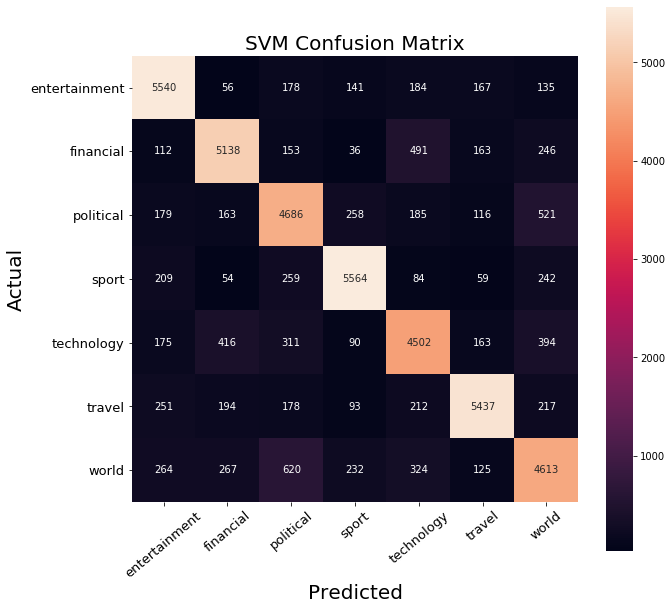

In [12]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix")

In [ ]:
# save the model as pickle
model_pkl = "svc_full_dataset.pkl"  

with open("data/"+model_pkl, 'wb') as file:  
    pickle.dump(svc, file)

### Conclusion

Using the full dataset our algorithm improved its accuracy by <b>8.2%!</b> Not bad, considering the memory and computing restrictions. <br/>
As future work, we could try the full dataset with lemma and stemming to see if it performs even better.

#### Extra: Testing a random political article from the web 

In [29]:
my_test_string = ["The 60-year-old leader of Chancellor Merkel's centre-right Christian Democrats (CDU) is premier of heavily industrial North Rhine-Westphalia (NRW), Germany's most populous state.Despite years of top-level political experience he struggled against a Bavarian rival for the candidacy - Markus Söder, leader of the CDU's junior partner, the Christian Social Union (CSU). Finally the Christian Democrat leadership rallied behind Mr Laschet, who now has to woo Mr Söder's many supporters.The pandemic has exacted a political toll on the two conservative parties: their support has slumped to roughly 28\% according to polls.Mr Laschet is the son of a mining engineer and for years defended Germany's powerful coal industry. He was late to back protection of the Hambach Forest near Cologne: much of it had already been felled to make way for brown coal (lignite) mining. Some question his commitment to decarbonisation, when the Greens are polling strongly and CO2 cuts are legally binding."]

transformed_string = dask_vectorizer.fit_transform(my_test_string)

svc.predict(transformed_string)

array(['political'], dtype='<U13')